# Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

np.random.seed(42)


In exercise 10, we learned basic signal processing techniques. We will apply those techniques in today's exercise on classification-based EMG signal to hand movement decoding.

The dataset used here is subject1's data in the second database from the Ninapro dataset (https://ninapro.hevs.ch/instructions/DB1.html). 

This dataset includes detailed information about the hand movements performed. Our objective now is to predict these movements using the EMG data by classification.

As always, first check the data structure

In [2]:
data = loadmat("S1_A1_E1.mat")
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
emg
stimulus
glove
subject
exercise
repetition
restimulus
rerepetition


In [3]:
emg = data["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

EMG data dimension: (101014, 10)
EMG data type: <class 'numpy.ndarray'>


Text(0, 0.5, 'Amplitude')

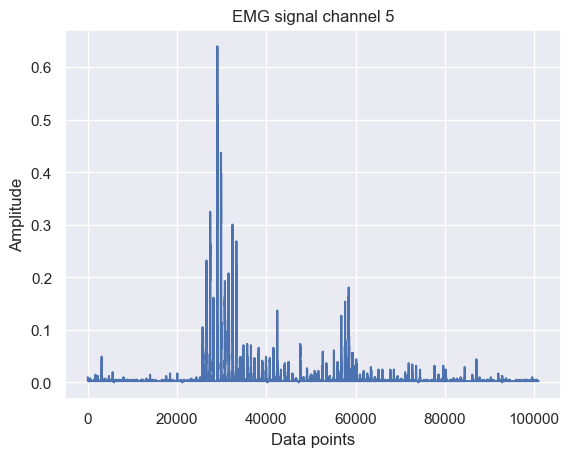

In [4]:
# Plot first channel to get a sense of the data
plt.close("all")
fig, ax = plt.subplots()
EMG_channel = 5
ax.plot(emg[:, EMG_channel])   
ax.set_title(f"EMG signal channel {EMG_channel}")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

In [5]:
stimulus = data['restimulus']
repetition = data['rerepetition']

Same as week 10, for each trial (one repetition of one stimulus) we create a nested list of envelopes of the trials.

In [6]:
n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition

mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

Then, using the provided code, we extract the features and build the dataset for classification later. In this simple example we will look at some simple features within the full window of each trial. 

In [7]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [8]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)


dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std]
    # features=[mav, std, maxav, rms, wl, ssc] # Uncomment this line to use all features once implemented
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")


dataset dimension: (120, 20)
labels dimension: (120,)


In [10]:
print("emg shape", emg.shape)
print("stimulus shape", stimulus.shape)

emg shape (101014, 10)
stimulus shape (101014, 1)


Since we have 12 actions and 10 repeats for each actions, we have a total of 120 training examples. This is a small classification problem.

Now, lets try to do some classification.

In this exercise, we will perform a basic classification task using a K nearest classifier. We will split our dataset into training and testing sets, normalize the data, train the CLF, and evaluate its performance. This process is fundamental in machine learning and helps us understand how well our model generalizes to unseen data.


Accuracy score: 0.8333333333333334


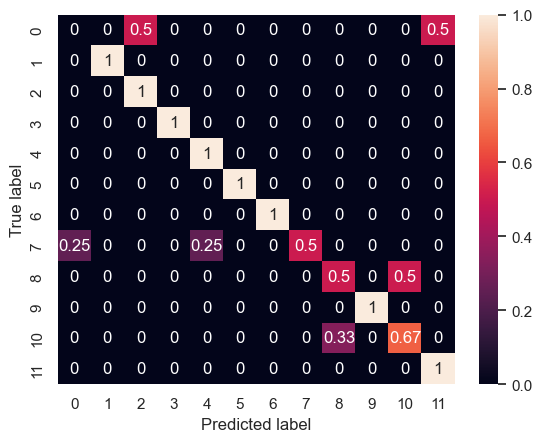

In [11]:

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Split the dataset into training and testing sets
# Here, 30% of the data is reserved for testing, and 70% is used for training
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3)

# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test)        # Transform the test data using the same scaler

# Train a classifier on the normalized data
# We are using K-Nearest Neighbors (KNN) from sklearn
clf = KNeighborsClassifier()
clf.fit(X_train_z, y_train)  # Fit the model on the training data

# Evaluate the classifier on the test set
# Predict the labels for the test set
y_pred = clf.predict(X_test_z)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification
# The confusion matrix shows the true vs predicted labels
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label");

## Cross-validation for evaluation

In the previous example, we used a random method to split the data into training and testing sets. It's important to note that the model's performance can vary significantly depending on this split. 

Therefore, in our next step, we plan to vary the composition of the training and testing datasets and train multiple models accordingly. This approach is known as cross-validation, and it helps in assessing the model's effectiveness more reliably by using different data subsets for training and testing.

### Cross-Validation in Machine Learning

Cross-validation is a key technique in machine learning for estimating model performance on independent datasets. It mitigates the limitations of a single train-test split, which can yield misleading metrics, especially with small or uneven datasets. The process involves dividing the dataset into 'k' folds, training the model on 'k-1' folds, and testing on the remaining fold, repeated 'k' times. Stratified K-Fold ensures each fold maintains the dataset's class distribution, crucial for imbalanced classes.

The advantages of cross-validation include providing a robust performance estimate by averaging results across folds, identifying overfitting, and aiding in hyperparameter tuning. Typically, it is implemented using `cross_val_score` from `sklearn.model_selection`, automating data splitting, training, and evaluation. This approach ensures reliable and generalizable model performance.

In [12]:
# perform cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train_z, y_train, cv=5)
print(f"Accuracy scores of all models: {scores}")
print(f"Mean accuracy across all models: {np.mean(scores)}")

Accuracy scores of all models: [0.82352941 0.70588235 0.76470588 0.82352941 0.6875    ]
Mean accuracy across all models: 0.7610294117647058


In the above code, the 5 different model is trained and evaluated. Each model is trained on a different training and testing set. We see that depending on how the data is split, the performance could vary from 0.64 to 0.76. Hence, we can then use the average performance for our evaluation.

## Hyperparameter optimization

Something that we can do to improve classification is also to optimize the parameters of the models. For instance, in the K nearest neighbour function on sklearn, we have the option to select various values for 'n_neighbors', 'weights'. To effectively test the different combinations of these parameters, we can utilize the GridSearchCV function of sklearn, which is designed to methodically identify the optimal combination of these parameters, thereby ensuring the best possible performance and accuracy for the model.

In [13]:
# use cross validation to find the best hyperparameters for SVC

from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_neighbors": [1,3,5,7,9],
    "weights": ['uniform', 'distance'],
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid)
grid.fit(X_train_z, y_train)

print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

y_pred = grid.predict(X_test_z)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of best model: {accuracy}")

Best estimator: KNeighborsClassifier(n_neighbors=1)
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform'}
Accuracy score of best model: 0.8611111111111112


We see how the accuracy increased by searching for the best parameters. 

# Feature importance/selection

In this example, we are dealing with a relatively small set of features. However, in scenarios where we encounter a larger number of features, it can be important to employ feature selection techniques to improve model performance and efficiency. 

For this purpose, we propose a method that utilizes functions like mutual_info_classif and SelectKBest from sklearn. 

Mutual_info_classif evaluates the mutual information between each feature and the target variable, providing an insight into the relevance of each feature. 

Meanwhile, SelectKBest allows us to select a specified number of features that have the highest scores according to a given scoring function, in this case, the mutual information.  
By combining these two functions, we can effectively reduce the feature space to those most relevant.

Estimated mutual information between each feature and the target:
 [0.81775805 0.78159812 0.69374481 0.71439798 0.61903446 0.64630158
 0.99183332 1.29473482 0.69589622 0.64730954 0.88943352 0.72369577
 0.81238432 0.74578658 0.61396559 0.668429   0.89279319 0.93992074
 0.74722546 0.7415165 ]



/Users/fedemengo/Documents/notes-vault/shared-vault/studies/neuro-x/epfl-neuro-x/C_NX-421-neural-signals-procs/NX_NSSP_public/venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=30 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Accuracy score of a model with k best features: 0.8611111111111112


Text(0.5, 20.049999999999997, 'Predicted label')

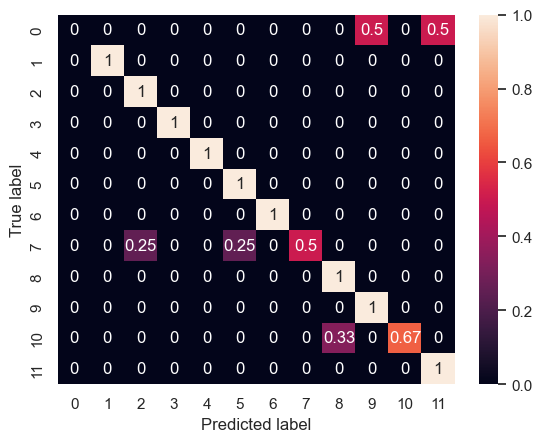

In [14]:
# Import necessary functions for feature selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# Calculate mutual information between each feature and the target variable.
# Mutual information is a measure of the dependency between variables.
# A higher value indicates a stronger relationship.
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

# Select the top 30 features based on mutual information scores.
# Note: You can change 'k' to 10 if you are working with fewer features.
k_best = SelectKBest(mutual_info_classif, k=30)
k_best.fit(X_train_z, y_train)

# Transform the training and test datasets to only include the selected features.
X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)

clf = KNeighborsClassifier(**grid.best_params_) # use the best parameters found before, You can also perform another round of grid search with the new features
clf.fit(X_train_best, y_train)

# Predict the labels for the test set using the trained model.
y_pred = clf.predict(X_test_best)

# Calculate the accuracy of the model with the selected features.
# Accuracy is the ratio of correctly predicted instances to the total instances.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of a model with k best features: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification model.
# The confusion matrix shows the true vs predicted labels.
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
